In [2]:
from datetime import datetime

print()
start = datetime.now()
print(f'Start Time : {start}')


Start Time : 2023-04-25 10:50:41.470065


In [3]:
from tabascal.optimize.mcmc import inv_kernel_vmap, inv_kernel, log_normal, log_multinorm
from tabascal.jax.coordinates import orbit, orbit_fisher
from tabascal.jax.interferometry import rfi_vis, _ants_to_bl
from tabascal.utils.tools import progress_bar_scan

from jax import random, jit, vmap, jacrev
import jax.numpy as jnp

from jax.flatten_util import ravel_pytree as flatten
from jax.lax import scan

from jax.tree_util import tree_map
import jax

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py

import xarray as xr 

plt.rcParams['font.size'] = 16

In [4]:
cal_path = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/calibrator_obs_64A_150T-0000-0298_128I_001F-1.227e+09-1.227e+09_001AST_1SAT_0GRD/"
# cal_path = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/calibrator_obs_64A_150T_128I_001F_001AST_1SAT_0GRD/"
# tar_path = "/Users/chrisfinlay/Documents/PhD/tabascal/tabascal/tabascal/examples/test_obs_64A_450T_128I_001F_100AST_1SAT_0GRD/"

In [125]:
def get_obs_info(ds_file_path, start_time_idx=0, n_time=-1, sampling=1):
    ds = xr.open_zarr(ds_file_path)
    
    if n_time == -1:
        n_time = int(ds.attrs["n_time"])
    
    a1 = ds.antenna1.data.compute()
    a2 = ds.antenna2.data.compute()
    
    n_int_samples = ds.attrs["n_int_samples"]//sampling
    n_time_fine = n_time*n_int_samples
    time_slice = np.arange(start_time_idx, n_time)
    time_slice_fine = np.arange(start_time_idx*n_int_samples, n_time_fine*sampling, sampling)
    
    ds_info = {
        'N_int_samples': n_int_samples,
        'N_ant': ds.attrs["n_ant"],
        'N_bl': ds.attrs["n_bl"],
        'N_time': n_time,
        'times': ds.coords["time"].data[time_slice],
        'times_fine': ds.coords["time_fine"].data[time_slice_fine],
        'bl_uvw': ds.bl_uvw.data[time_slice_fine].compute(),
        'ants_uvw': ds.ants_uvw.data[time_slice_fine, :].compute(),
        'ants_xyz': ds.ants_xyz.data[time_slice_fine, :].compute(),
        'ants_enu': ds.ants_enu.data[:, :].compute(),
        'bl_enu': ds.ants_enu.data[a1, :].compute() - ds.ants_enu.data[a2, :].compute(),
        'vis_ast': ds.vis_ast.data[time_slice_fine, :, 0].compute(),
        'vis_rfi': ds.vis_rfi.data[time_slice_fine, :, 0].compute(),
        'vis_obs': ds.vis_obs.data[time_slice, :, 0].compute(),
        'noise': ds.noise_std.data.compute(),
        'noise_data': ds.noise_data.data[time_slice, :, 0].compute(),
        'int_time': ds.attrs["int_time"],
        'freqs': ds.coords["freq"].data,
        'gains_ants': ds.gains_ants.data[time_slice_fine, :, 0].compute(),
        'rfi_A_app': ds.rfi_sat_A.data[0, time_slice_fine, :, 0].compute(),
        'rfi_orbit': ds.rfi_sat_orbit.data[0].compute(),
        'target_dec': ds.attrs["target_dec"]
    }
    
    ds.close()
    
    return ds_info

In [335]:
ds = get_obs_info(cal_path, n_time=-1, sampling=1)
# ds = get_obs_info(tar_path)

In [367]:
N_ant = ds['N_ant']
N_bl = ds['N_bl']
N_time = ds['N_time']
N_int_samples = ds['N_int_samples']

In [368]:
from tabascal.jax.coordinates import G, M_e, R_e, T_s
from tabascal.jax.interferometry import c

lamda = c / ds['freqs']

w_rate = -2*jnp.pi/T_s*(ds['bl_uvw'][:,:,0]/lamda)*jnp.cos(jnp.deg2rad(ds['target_dec']))

omega_sat = jnp.sqrt(G*M_e/(R_e+ds['rfi_orbit'][0])**3)
inclination = jnp.deg2rad(ds['rfi_orbit'][1])
sat_vel = omega_sat*jnp.array([jnp.cos(inclination), jnp.sin(inclination)])

rfi_rate = jnp.dot(ds['bl_enu'][:,:2], sat_vel)/lamda - (2*jnp.pi/T_s) / (ds['bl_enu'][:,0]/lamda) + w_rate 

In [409]:
jnp.pi * jnp.abs(rfi_fringe).max() * jnp.sqrt( (ds['rfi_A_app']**2).max()/ (6*ds['noise']) )

Array([13.70492536], dtype=float64)

In [411]:
(ds['rfi_A_app']**2).max()

43.0880705665836

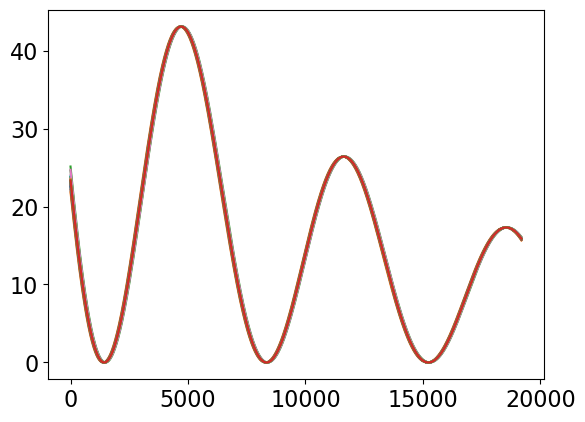

In [369]:
plt.plot(ds['rfi_A_app']**2);

In [338]:
rfi_amp = np.abs(ds['vis_rfi']).reshape(N_time, N_int_samples, -1).mean(axis=1)

In [339]:
vis_rfi_true = ds['vis_rfi'].reshape(N_time, N_int_samples, -1).mean(axis=1)

In [366]:
N_int_samples

128

In [438]:
np.rad2deg(jnp.arcsin(0.65/43)/np.sqrt(63))

0.1091223724894831

In [439]:
np.rad2deg(jnp.arcsin(0.65)/np.sqrt(63))

5.107761729023013

In [440]:
np.rad2deg((0.65)/np.sqrt(63))

4.692083307018258

In [436]:
sig_p, sig_a = np.rad2deg(jnp.arcsin(0.65)/np.sqrt(63)), 100*0.65/np.sqrt(63)

In [437]:
np.sqrt(1/(1/(10**2) + 1.2/(sig_p**2)))

4.225922516830644

In [373]:
vis_rfi_2 = ds['vis_rfi'][1::2].reshape(N_time, N_int_samples//2, -1).mean(axis=1)
vis_rfi_4 = ds['vis_rfi'][2::4].reshape(N_time, N_int_samples//4, -1).mean(axis=1)
vis_rfi_8 = ds['vis_rfi'][4::8].reshape(N_time, N_int_samples//8, -1).mean(axis=1)
vis_rfi_16 = ds['vis_rfi'][8::16].reshape(N_time, N_int_samples//16, -1).mean(axis=1)
vis_rfi_32 = ds['vis_rfi'][16::32].reshape(N_time, N_int_samples//32, -1).mean(axis=1)
vis_rfi_64 = ds['vis_rfi'][32::64].reshape(N_time, N_int_samples//64, -1).mean(axis=1)

In [425]:
list(zip(32//2**np.arange(5), np.round(np.abs(errors).max(axis=(1,2)), 3)))

[(32, 0.336), (16, 0.34), (8, 0.409), (4, 1.061), (2, 6.335)]

In [415]:
jnp.abs(vis_rfi_4-vis_rfi_true).max()

Array(0.34032272, dtype=float64)

In [374]:
errors = jnp.stack([(vis_rfi_true-v) for v in [vis_rfi_2, vis_rfi_4, vis_rfi_8, vis_rfi_16, vis_rfi_32, vis_rfi_64]])

In [375]:
rfi_fringe = jnp.diff(jnp.unwrap(2*jnp.arctan(ds['vis_rfi'].imag/ds['vis_rfi'].real), axis=0, discont=0.)/(2*2*jnp.pi), axis=0)/jnp.diff(ds['times_fine'])[:,None]
mean_rfi_fringe = jnp.abs(jnp.concatenate([rfi_fringe, rfi_fringe[-2:-1]], axis=0)).reshape(N_time, N_int_samples, -1).mean(axis=1)

In [376]:
errors.mean(axis=(1,2)), errors.std(axis=(1,2))

(Array([-8.50190706e-06+3.41574325e-06j, -8.69297910e-06+3.59780290e-06j,
        -9.45830792e-06+4.33738954e-06j, -1.25224062e-05+7.54111797e-06j,
        -2.37312567e-05+2.68136204e-05j,  7.14434881e-04+1.46504421e-03j],      dtype=complex128),
 Array([0.08645433, 0.08655347, 0.08792473, 0.10766452, 0.30018279,
        2.33422363], dtype=float64))

[]

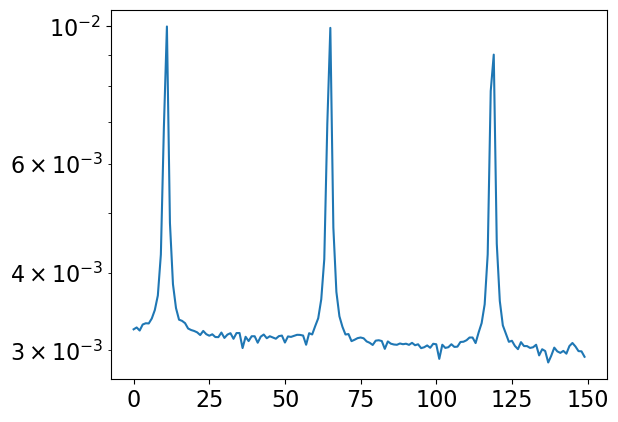

In [404]:
plt.plot((errors[0]/rfi_amp).real.std(axis=1));
plt.semilogy()

In [383]:
samp_rate = 2/(N_int_samples/2**np.arange(1, 7))

[]

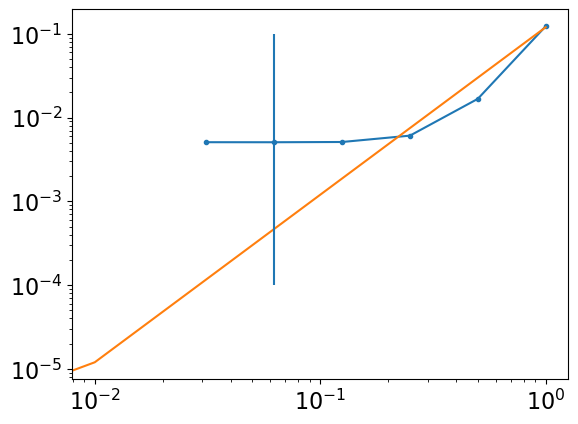

In [410]:
x = np.linspace(0, 1, 101)
y = 0.12*x**2
plt.plot(samp_rate, (errors/rfi_amp[None,:,:]).std(axis=(1,2)), '.-')
plt.plot(x, y)
plt.vlines(1./16., 1e-4, 1e-1)
plt.loglog()

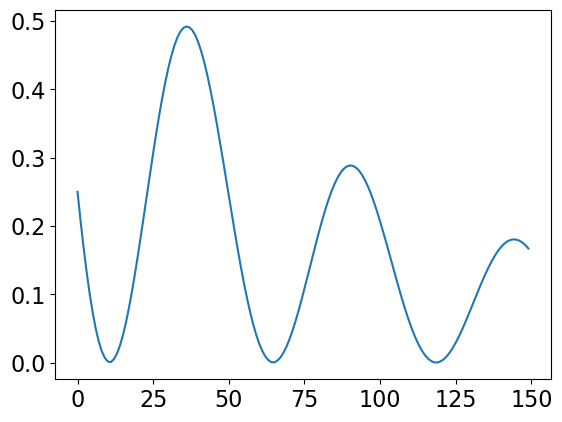

In [364]:
plt.plot(np.abs(errors[0,:,0]))

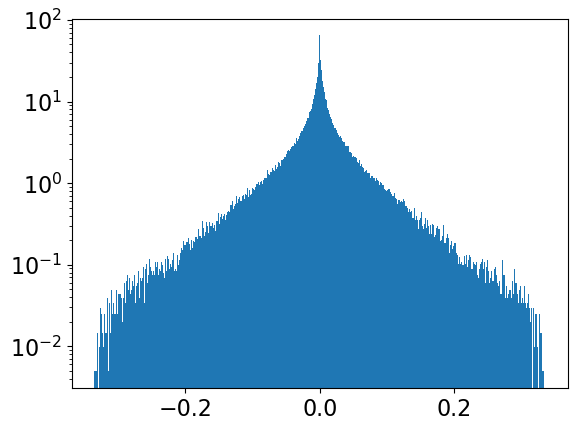

In [396]:
plt.hist(errors[0].real.flatten(), bins=1000, log=True, density=True);

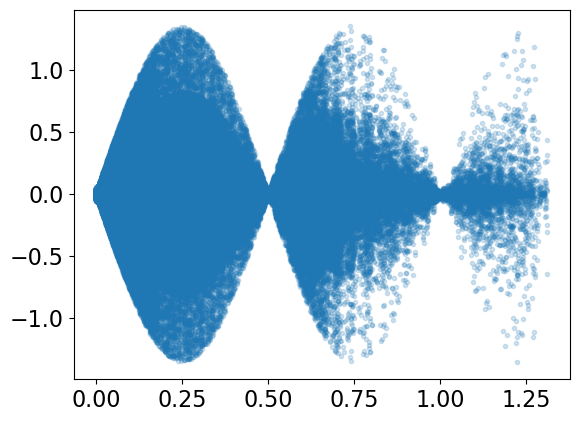

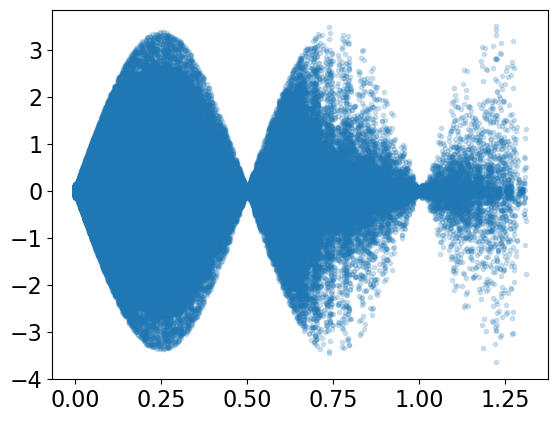

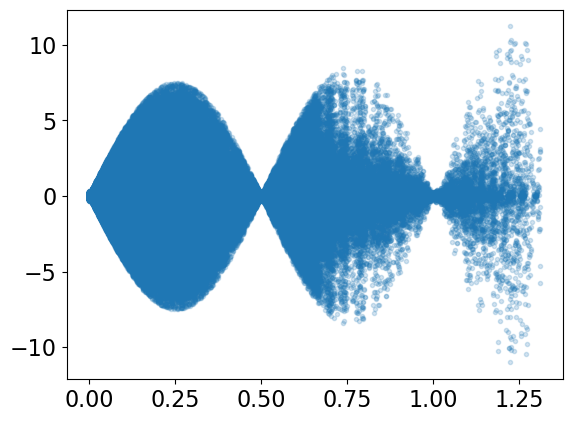

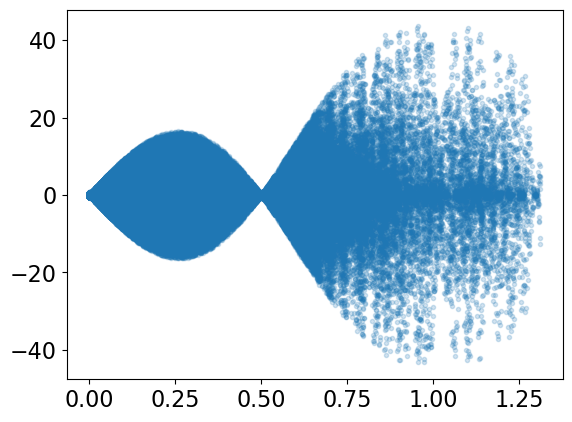

In [352]:
for e in errors:
    plt.figure()
    plt.plot(mean_rfi_fringe.flatten(), (e).flatten(), '.', alpha=0.2)

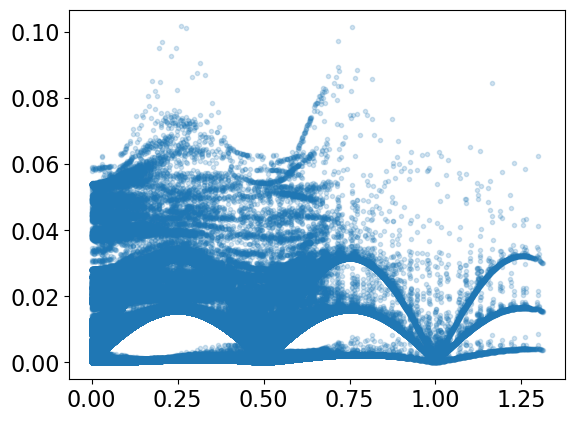

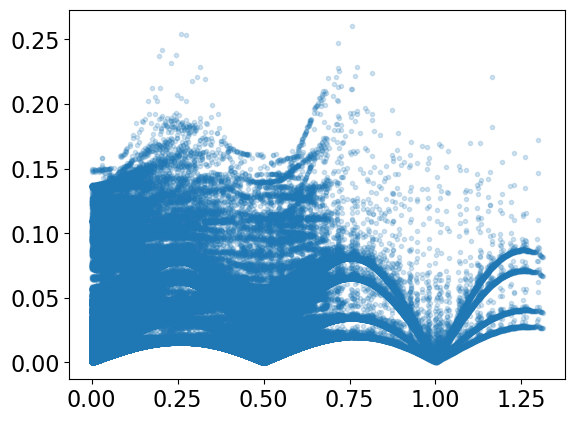

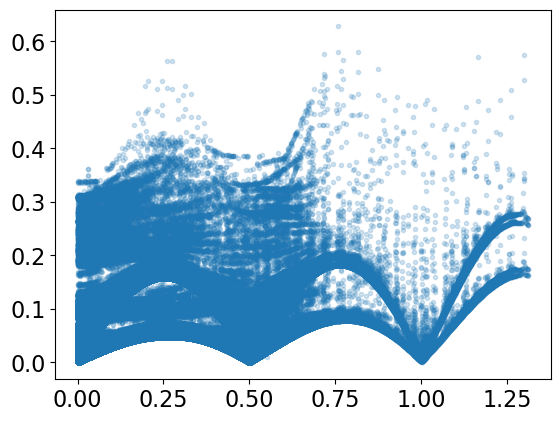

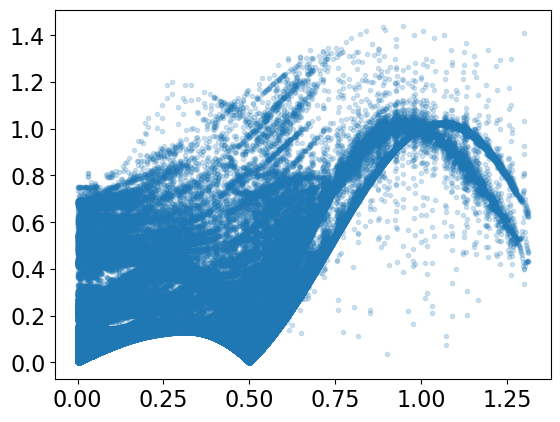

In [346]:
for e in errors:
    plt.figure()
    plt.plot(mean_rfi_fringe.flatten(), (e/rfi_amp).flatten(), '.', alpha=0.2)

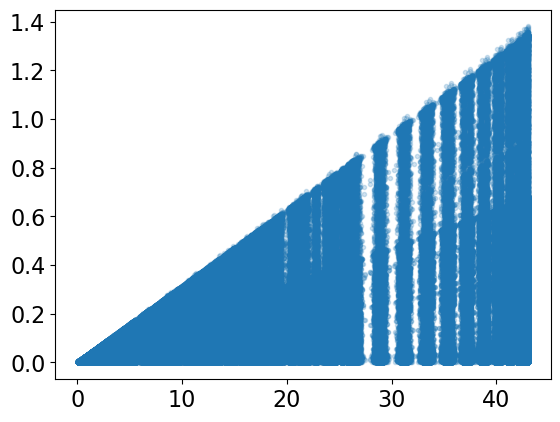

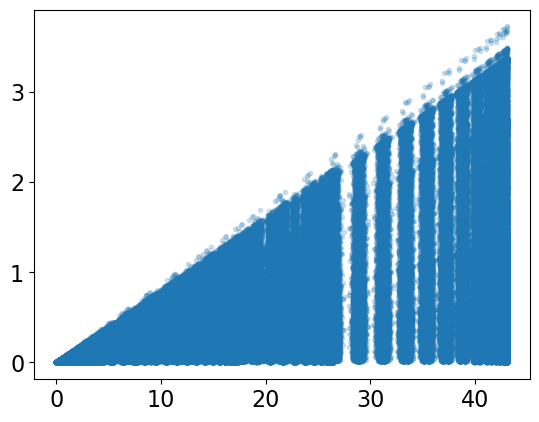

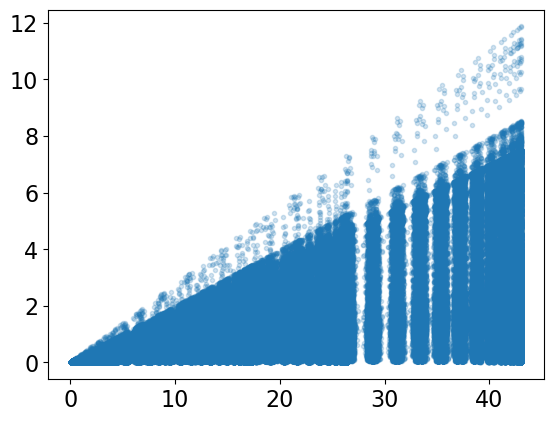

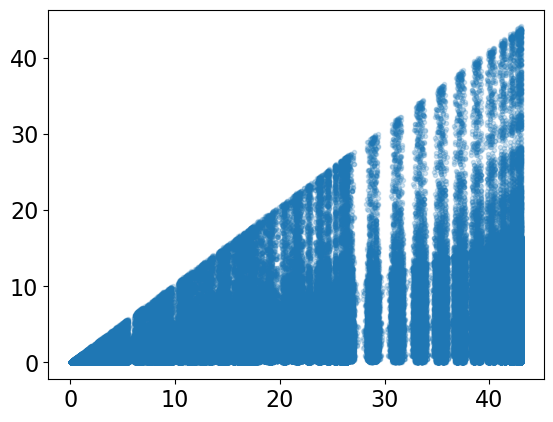

In [347]:
for e in errors:
    plt.figure()
    plt.plot(rfi_amp.flatten(), e.flatten(), '.', alpha=0.2)

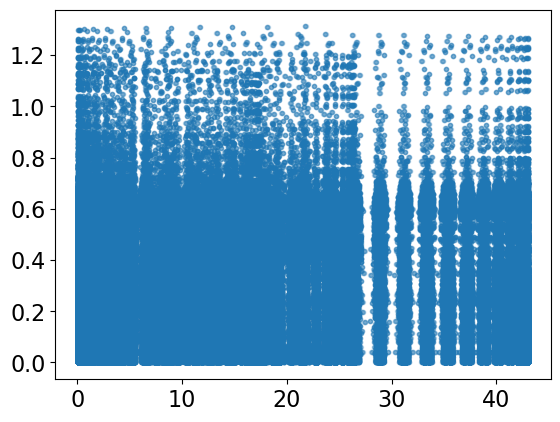

In [348]:
plt.plot(rfi_amp.flatten(), mean_rfi_fringe.flatten(), '.', alpha=0.2)

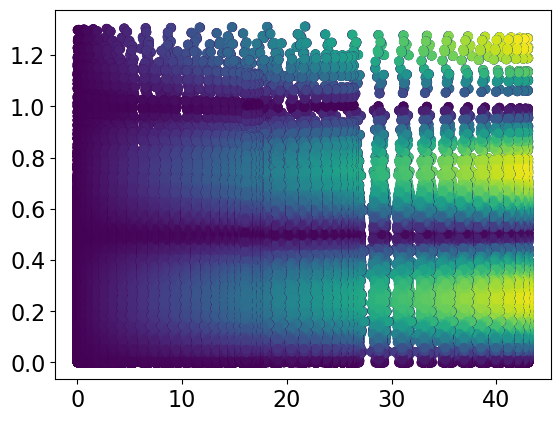

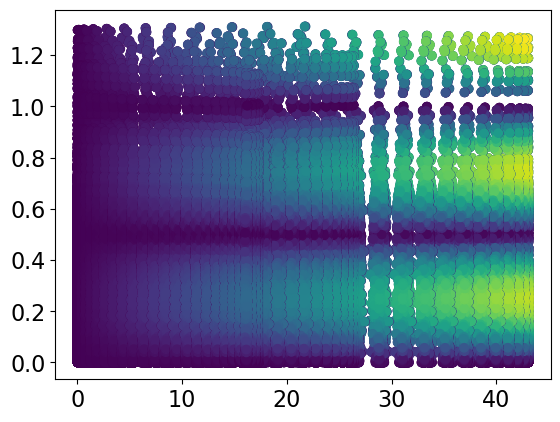

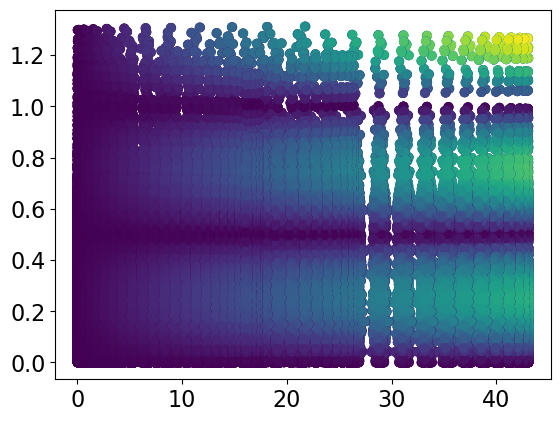

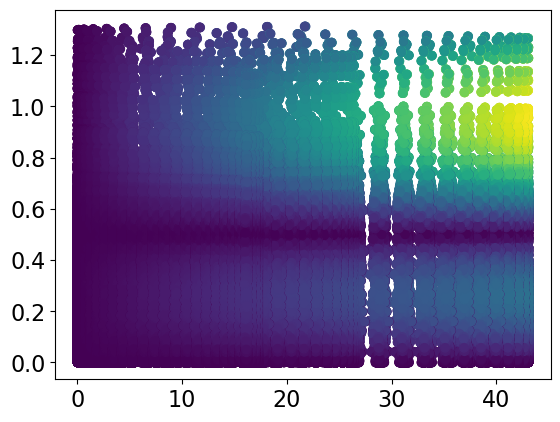

In [349]:
for e in errors:
    plt.figure()
    plt.scatter(rfi_amp.flatten(), mean_rfi_fringe.flatten(), c=e.flatten())

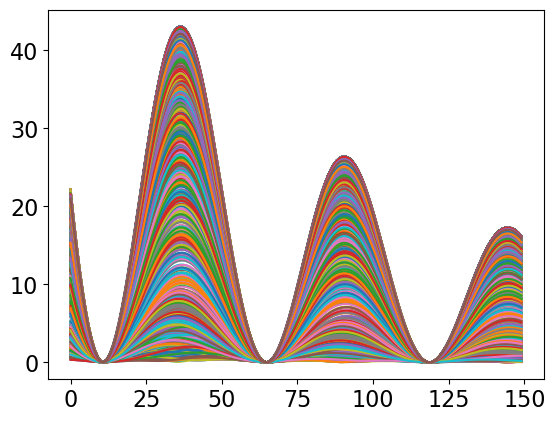

In [307]:
plt.plot(jnp.abs(vis_rfi_true));

In [ ]:
errors = 

In [294]:
(40/0.65)*jnp.pi**2/6*2

202.45342361208938

In [295]:
jnp.pi*(40/(6*0.65))

32.221463113741464

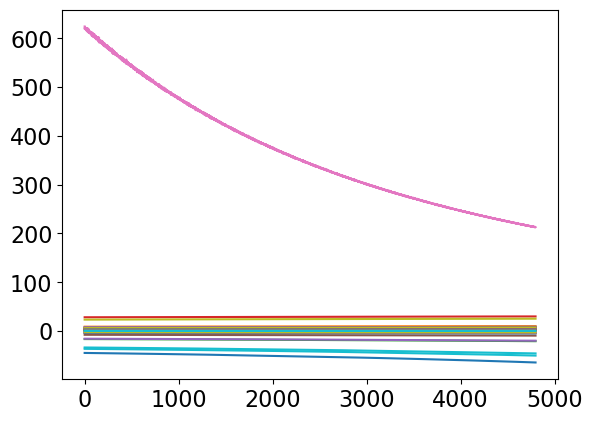

In [187]:
plt.plot(rfi_rate[1:,:100]/rfi_fringe[:,:100]);

In [269]:
x = np.linspace(-20, 20, 2**10)
y = 2*x
y[x<-1] = 0
y[x>1] = 0

X = np.fft.fftshift(np.fft.fftfreq(len(x), np.diff(x)[0]))
Y = np.fft.fftshift(np.fft.fft(y, norm='ortho'))

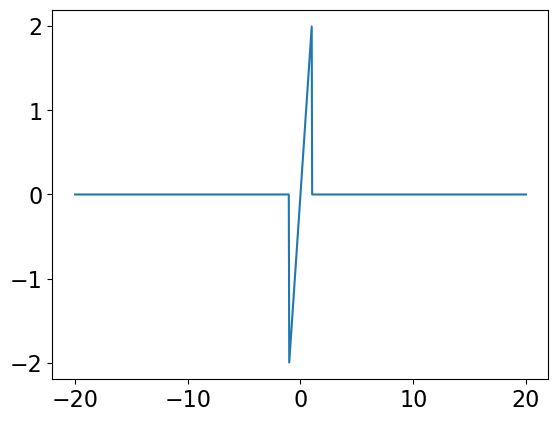

In [286]:
plt.plot(x, y)

(-10.0, 10.0)

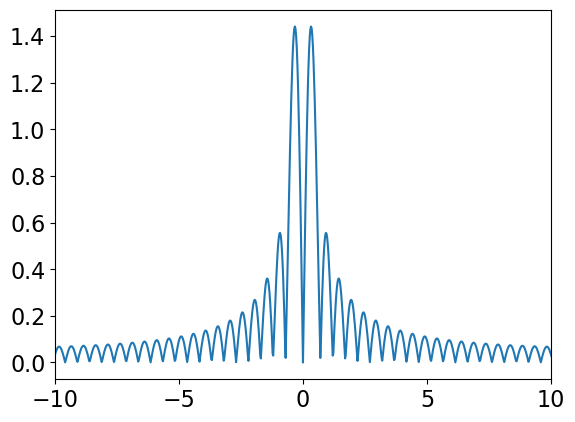

In [287]:
# plt.plot(X, (Y).real)
# plt.plot(X, (Y).imag)
plt.plot(X, np.abs(Y))
# plt.plot(X, 2.4*np.abs((np.cos(5*X)-np.sinc(5*X))/(5*X)))
plt.xlim(-10, 10)

In [17]:
N_ant = ds['N_ant']
N_bl = ds['N_bl']
N_time = ds['N_time']
N_int_samples = ds['N_int_samples']

In [18]:
rfi_fringe = jnp.diff(jnp.unwrap(2*jnp.arctan(ds['vis_rfi'].imag/ds['vis_rfi'].real), axis=0, discont=0.)/(2*2*jnp.pi), axis=0)/jnp.diff(ds['times_fine'])[:,None]

(-0.01, 0.01)

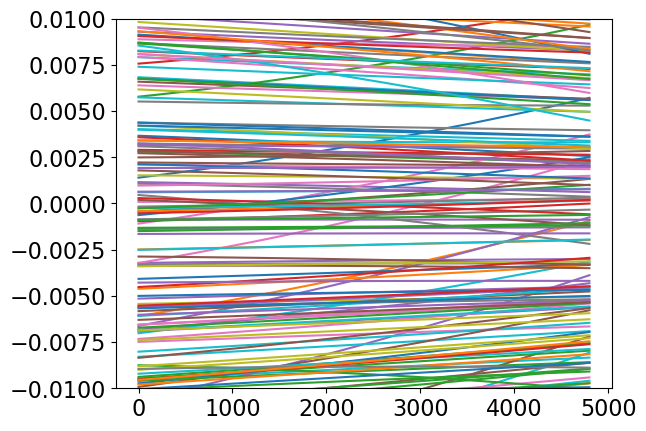

In [19]:
plt.plot(rfi_fringe);
plt.ylim(-1e-2, 1e-2)

In [20]:
np.abs(rfi_fringe).min()

0.0

In [21]:
rfi_factor = 1e0
vis_rfi = (rfi_factor*ds['vis_rfi'].reshape(N_time, N_int_samples, N_bl).mean(axis=1)[:,None,:]*jnp.ones((1,N_int_samples,1))).reshape(-1, N_bl)
amp_reduc = np.abs(vis_rfi/(rfi_factor*ds['vis_rfi'])).reshape(N_time, N_int_samples, N_bl).mean(axis=1)

In [22]:
idx = np.argmax(np.max(amp_reduc, axis=1))
bl_min = np.argmax(amp_reduc, axis=1)[idx]

In [23]:
idx = np.argmin(np.min(amp_reduc, axis=1))
bl_max = np.argmin(amp_reduc, axis=1)[idx]

In [24]:
idx = np.argmin(np.mean(amp_reduc, axis=1))
np.argmin(amp_reduc, axis=1)[idx]

1863

In [25]:
mag_uvw = np.linalg.norm(ds['bl_uvw'][0], axis=-1)
bl_max_len = np.argmax(mag_uvw)

Text(0.5, 1.0, 'Stepped is Averaged of Smooth Curve')

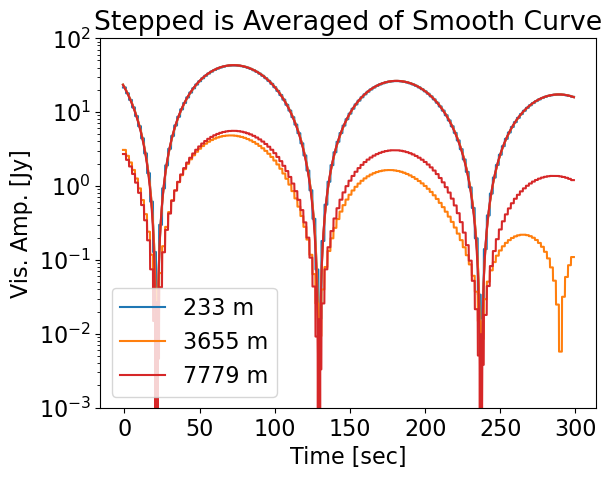

In [26]:
plt.plot(ds['times_fine'], np.abs(rfi_factor*ds['vis_rfi'][:,bl_min]), color='tab:blue', label=f'{mag_uvw[bl_min]:.0f} m')
plt.plot(ds['times_fine'], np.abs(vis_rfi[:,bl_min]), color='tab:blue')

plt.plot(ds['times_fine'], np.abs(rfi_factor*ds['vis_rfi'][:,bl_max]), color='tab:orange', label=f'{mag_uvw[bl_max]:.0f} m')
plt.plot(ds['times_fine'], np.abs(vis_rfi[:,bl_max]), color='tab:orange')

plt.plot(ds['times_fine'], np.abs(rfi_factor*ds['vis_rfi'][:,bl_max_len]), color='tab:red', label=f'{mag_uvw[bl_max_len]:.0f} m')
plt.plot(ds['times_fine'], np.abs(vis_rfi[:,bl_max_len]), color='tab:red')

plt.semilogy()
plt.ylim(rfi_factor*1e-3, rfi_factor*1e2)
plt.legend()

plt.xlabel('Time [sec]')
plt.ylabel('Vis. Amp. [Jy]')
plt.title('Stepped is Averaged of Smooth Curve')

In [103]:
cut_off = 1e-2
mean_amp_reduc = jnp.nanmean(jnp.where(jnp.abs(rfi_factor*ds['vis_rfi'])>cut_off, jnp.abs(vis_rfi/(rfi_factor*ds['vis_rfi'])), jnp.nan), axis=0)
std_amp_reduc = jnp.nanstd(jnp.where(jnp.abs(rfi_factor*ds['vis_rfi'])>cut_off, jnp.abs(vis_rfi/(rfi_factor*ds['vis_rfi'])), jnp.nan), axis=0)

mean_rfi_fringe = jnp.abs(jnp.concatenate([rfi_fringe, rfi_fringe[-2:-1]], axis=0)).mean(axis=0)

In [112]:
idx = jnp.argsort(mean_rfi_fringe)

mean_amp_reduc = mean_amp_reduc[idx]
std_amp_reduc = std_amp_reduc[idx]
mean_rfi_fringe = mean_rfi_fringe[idx]

(0.01, 1.5)

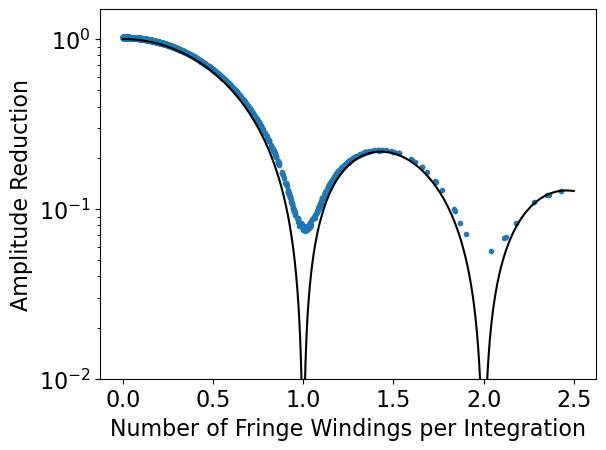

In [116]:
n = jnp.linspace(0, 2.5, 1001)
y = jnp.abs(jnp.sinc(n))

plt.plot(mean_rfi_fringe*2, mean_amp_reduc, '.')
# plt.errorbar(x=mean_rfi_fringe*2, y=mean_amp_reduc, yerr=std_amp_reduc, fmt='.', alpha=0.2)
plt.plot(n, y, 'k')
plt.xlabel('Number of Fringe Windings per Integration')
plt.ylabel('Amplitude Reduction')
plt.semilogy()
plt.ylim(1e-2, 1.5)

Text(0, 0.5, 'Amplitude Reduction Factor')

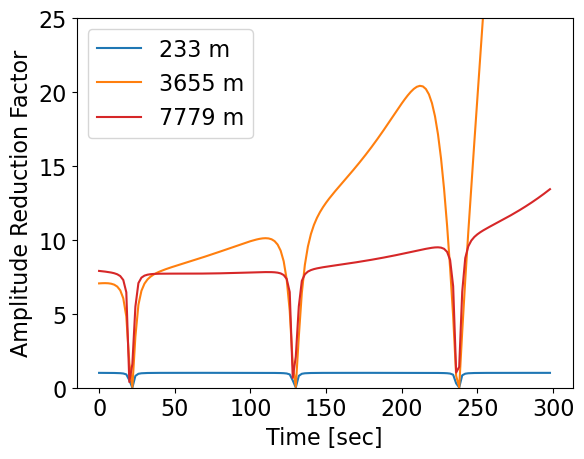

In [27]:
plt.plot(ds['times'], 1./amp_reduc[:,bl_min], color='tab:blue', label=f'{mag_uvw[bl_min]:.0f} m')
plt.plot(ds['times'], 1./amp_reduc[:,bl_max], color='tab:orange', label=f'{mag_uvw[bl_max]:.0f} m')
plt.plot(ds['times'], 1./amp_reduc[:,bl_max_len], color='tab:red', label=f'{mag_uvw[bl_max_len]:.0f} m')
plt.legend()
# plt.semilogy()
plt.ylim(0, 25)
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude Reduction Factor')

Text(0, 0.5, 'RFI Fringe Frequency [Hz]')

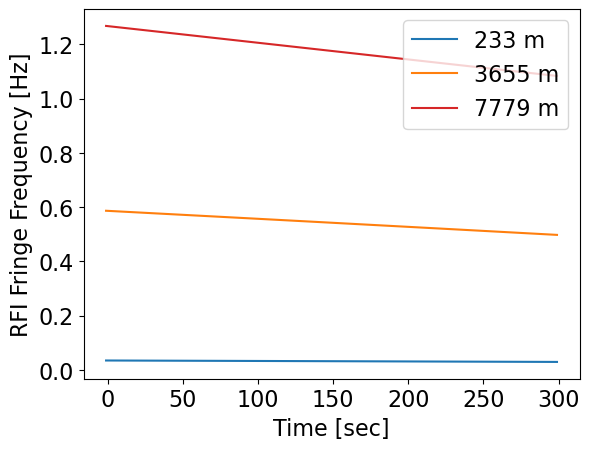

In [84]:
plt.plot(ds['times_fine'][:-1], rfi_fringe[:,bl_min], color='tab:blue', label=f'{mag_uvw[bl_min]:.0f} m')
plt.plot(ds['times_fine'][:-1], rfi_fringe[:,bl_max], color='tab:orange', label=f'{mag_uvw[bl_max]:.0f} m')
plt.plot(ds['times_fine'][:-1], rfi_fringe[:,bl_max_len], color='tab:red', label=f'{mag_uvw[bl_max_len]:.0f} m')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('RFI Fringe Frequency [Hz]')

(-30.0, 30.0)

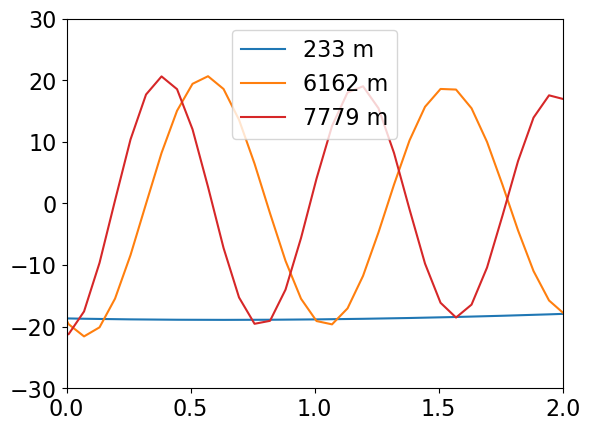

In [16]:
plt.plot(ds['times_fine'], rfi_factor*ds['vis_rfi'].real[:,bl_min], color='tab:blue', label=f'{mag_uvw[bl_min]:.0f} m')
plt.plot(ds['times_fine'], rfi_factor*ds['vis_rfi'].real[:,bl_max], color='tab:orange', label=f'{mag_uvw[bl_max]:.0f} m')
plt.plot(ds['times_fine'], rfi_factor*ds['vis_rfi'].real[:,bl_max_len], color='tab:red', label=f'{mag_uvw[bl_max_len]:.0f} m')
plt.legend()
plt.xlim(0,2)
plt.ylim(-3e1, 3e1)

In [85]:
rfi_fringe = jnp.diff(jnp.unwrap(2*jnp.arctan(ds['vis_rfi'].imag/ds['vis_rfi'].real), axis=0, discont=0.)/(2*2*jnp.pi), axis=0)/jnp.diff(ds['times_fine'])[:,None]

In [86]:
ast_fringe = jnp.diff(jnp.unwrap(2*jnp.arctan(ds['vis_ast'].imag/ds['vis_ast'].real), axis=0, discont=0.)/(2*2*jnp.pi), axis=0)/jnp.diff(ds['times_fine'])[:,None]

In [88]:
np.abs(rfi_fringe).max()

1.3120472392267089

In [95]:
ds['bl_uvw'].shape

(4800, 2016, 3)

Array([-0.12548102, -0.17598431, -0.14575881, ..., -0.01283781,
        0.04248529,  0.0553231 ], dtype=float64)

(array([   3.,   53.,  101.,  139., 1086.,  372.,  145.,   97.,   14.,
           6.]),
 array([-2.73579291, -2.14255197, -1.54931102, -0.95607008, -0.36282914,
         0.23041181,  0.82365275,  1.41689369,  2.01013464,  2.60337558,
         3.19661652]),
 <BarContainer object of 10 artists>)

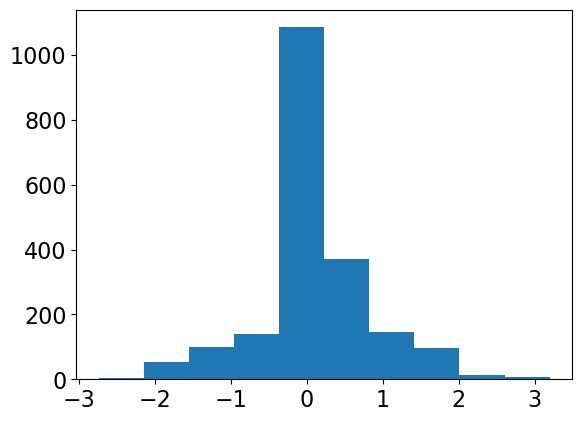

In [105]:
plt.hist(rfi_fringe.mean(axis=0) + (2*jnp.pi/T_s*(ds['bl_uvw'][:,:,0]*ds['freqs']/c)*jnp.cos(jnp.deg2rad(ds['target_dec']))).mean(axis=0))

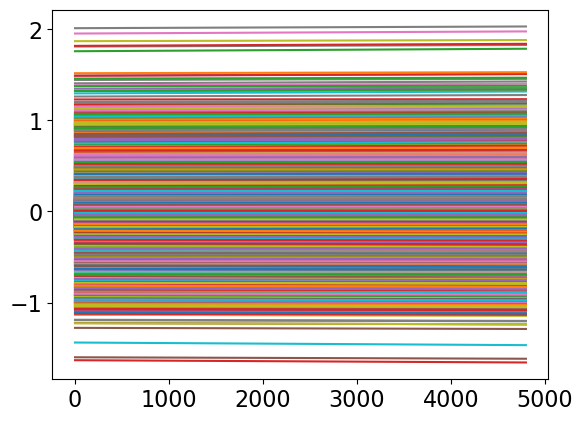

In [118]:
plt.plot(2*jnp.pi/T_s*(ds['bl_uvw'][:,:,0]*ds['freqs']/c)*jnp.cos(jnp.deg2rad(ds['target_dec'])));

In [16]:
from tabascal.jax.coordinates import T_s
from tabascal.jax.interferometry import c

max_w_rate = np.abs(2*jnp.pi/T_s*(ds['bl_uvw'][:,:,0]*ds['freqs']/c)*jnp.cos(jnp.deg2rad(ds['target_dec']))).max()
print(f'Fringe rate for stationary RFI sources: {round(max_w_rate,4)} 1/s')

Fringe rate for stationary RFI sources: 2.0301 1/s


Maximum fringe rate for RFI source: 1.312 Hz


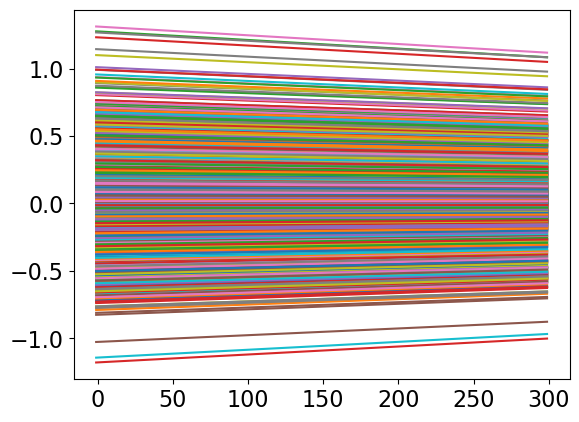

In [106]:
plt.plot(ds['times_fine'][:-1], rfi_fringe[:,:]);
# plt.xlim(0, 1)
print(f'Maximum fringe rate for RFI source: {round(rfi_fringe.max(),4)} Hz')

In [20]:
rfi_fringe.shape

(959, 2016)

In [21]:
np.argmax(rfi_fringe[0,:])

Array(1866, dtype=int64)

In [22]:
rfi_fringe.max()

Array(1.31204724, dtype=float64)

In [23]:
# plt.plot(rfi_fringe[:,:10]);

In [24]:
# plt.plot(ast_fringe[:,:10]);
# plt.ylim(-1e-2, 1e-2)

In [25]:
# plt.hist(jnp.abs(rfi_fringe).mean(axis=0), bins=100, alpha=0.3, label='RFI')
# plt.hist(jnp.abs(ast_fringe).mean(axis=0), bins=100, alpha=0.3, label='AST')
# plt.legend()
# plt.semilogx()

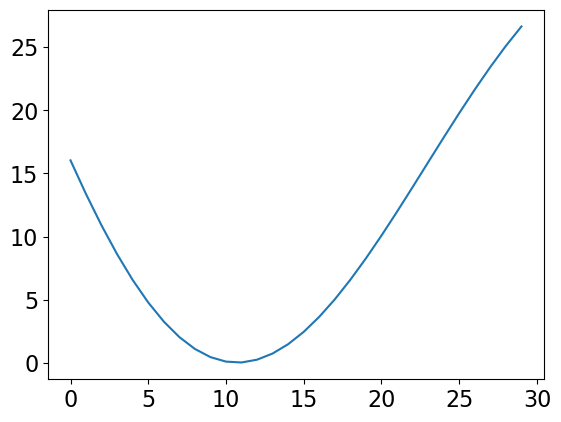

In [26]:
plt.plot(np.mean(np.abs(ds['vis_rfi'].reshape(N_time, N_int_samples, -1).mean(axis=1)), axis=1))
# plt.plot(np.mean(np.abs(ds['vis_rfi']), axis=1))

In [27]:
rfi_factor = 1e0
a1, a2 = jnp.triu_indices(N_ant, 1)
G_bl = _ants_to_bl(ds['gains_ants'][:,:,None], a1, a2)[:,:,0]
vis_obs = ( G_bl * (ds['vis_ast'] + rfi_factor*ds['vis_rfi']) ).reshape(N_time, N_int_samples, N_bl).mean(axis=1) + ds['noise_data']
rfi_A_app = jnp.sqrt(rfi_factor) * ds['rfi_A_app']

print(f'Mean RFI Amplitude: {jnp.abs(rfi_factor*ds["vis_rfi"].reshape(N_time, N_int_samples, N_bl).mean(axis=1)).mean():.2f} Jy')

Mean RFI Amplitude: 9.39 Jy


In [28]:
SNR = jnp.abs(rfi_factor*ds['vis_rfi']/ds['noise']).mean(axis=0).max()
fringe_freq = jnp.abs(rfi_fringe).max()

delta_t = 1./(jnp.pi*fringe_freq) * jnp.sqrt(6./SNR)

In [29]:
delta_t/jnp.diff(ds['times_fine'])[0]

Array(2.1490524, dtype=float64)

In [30]:
# Set Constant Parameters
params = {'freqs': ds['freqs'],
          'times': ds['times'],
          'times_fine': ds['times_fine'],
          'noise': ds['noise'],
          'ants_xyz': ds['ants_xyz'],
          'phase_corrections': ds['ants_uvw'][...,-1],
          'vis_cal': ds['vis_ast'].reshape(N_time,N_int_samples,
                                          N_bl).mean(axis=1),
          'vis_obs': vis_obs,
          }

In [31]:
RIC_std = jnp.array([73.0, 131.0, 54.0])  

prior_dev = 0.5

G_amp_dev = 0.1
G_phase_dev = 10.
orbit_dev = 2.

In [32]:
# Calculate Prior Parameter Values

max_sigma = 3
G_amp_mean = jnp.mean(jnp.abs(ds['gains_ants']), axis=0)[None,:]
G_amp = ( G_amp_mean + \
          prior_dev*G_amp_dev*G_amp_mean * \
          random.truncated_normal(random.PRNGKey(105), lower=-max_sigma, upper=max_sigma,
                                  shape=(1, N_ant)) ) * \
        jnp.ones((N_time, N_ant))

G_phase_mean = jnp.mean(jnp.angle(ds['gains_ants']), axis=0)[None,:]
G_phase = ( G_phase_mean + \
            prior_dev*jnp.deg2rad(G_phase_dev) * \
            random.truncated_normal(random.PRNGKey(106), lower=-max_sigma, upper=max_sigma,
                                    shape=(1, N_ant)) ) * \
          jnp.ones((N_time, N_ant))

G = G_amp*jnp.exp(1.j*G_phase)

sym = lambda x: 0.5 * (x+x.T) 

inv_cov_RFI_orbit = sym(orbit_fisher(ds['times'], ds['rfi_orbit'], orbit_dev*RIC_std)/(N_time))
rfi_orbit = random.multivariate_normal(random.PRNGKey(107), ds['rfi_orbit'],
                                       prior_dev**2*jnp.linalg.inv(inv_cov_RFI_orbit))


prior_params = {
    'mu_RFI_orbit': rfi_orbit,
    'inv_cov_RFI_orbit': inv_cov_RFI_orbit,
    'rfi_amp_std': 100.0,
    'mu_G_amp': G_amp,
    'G_amp_std': G_amp_dev*G_amp_mean*jnp.ones((N_time, N_ant)),
    'mu_G_phase': G_phase[:,:-1],
    'G_phase_std': jnp.deg2rad(G_phase_dev),
}

params.update(prior_params)

true_values = {
    'g_amp': jnp.abs(ds['gains_ants'][N_int_samples//2::N_int_samples]).flatten(),
    'g_phase': jnp.angle(ds['gains_ants'][N_int_samples//2::N_int_samples,:-1]).flatten(),
    'rfi_amp': rfi_A_app[N_int_samples//2::N_int_samples].flatten(),
    'rfi_orbit': ds['rfi_orbit'],
}

def calc_rfi_amp(G):
    return jnp.sqrt(jnp.max(jnp.abs(params['vis_obs']/_ants_to_bl(G[:,:,None], a1, a2)[:,:,0] -
                                    params['vis_cal']), axis=1, keepdims=True))* \
           jnp.ones((1,N_ant))

qi_std = 0.5

N_qi = 100
rng = np.random.default_rng(123)

G_amp = rng.normal(prior_params['mu_G_amp'], qi_std*prior_params['G_amp_std'], size=(N_qi, N_time, N_ant))
G_phase = rng.normal(prior_params['mu_G_phase'], qi_std*prior_params['G_phase_std'], size=(N_qi, N_time, N_ant-1))
G_phase = jnp.concatenate([G_phase, jnp.zeros((N_qi, N_time, 1))], axis=-1)
G = G_amp*jnp.exp(1.j*G_phase)
rfi_A = vmap(calc_rfi_amp)(G)
rfi_orbit = rng.multivariate_normal(prior_params['mu_RFI_orbit'], qi_std**2*jnp.linalg.inv(prior_params['inv_cov_RFI_orbit']), size=(N_qi,))


qi = {
    'g_amp': G_amp.reshape(N_qi, -1)/0.98, # (Nt,Na,Nf)
    'g_phase': G_phase[...,:-1].reshape(N_qi, -1), # (Nt,Na-1,Nf)
    'rfi_amp': rfi_A.reshape(N_qi, -1)*0.98,
    'rfi_orbit': rfi_orbit,
}

In [33]:
##### Create Functions needed in MCMC
@jit
def linear_extrapolate(x, xp, fp):

    N_ext = int(N_int_samples/2)

    xi = x[:N_ext]
    xf = x[-N_ext:]

    x_int = x[N_ext:-N_ext]
    y_int = jnp.interp(x_int, xp, fp)

    dyi = (y_int[1]-y_int[0])/(x_int[1]-x_int[0])
    dyf = (y_int[-1]-y_int[-2])/(x_int[-1]-x_int[-2])

    yi = y_int[0] + dyi*(xi - xp.min())
    yf = y_int[-1] + dyf*(xf - xp.max())

    return jnp.concatenate([jnp.array(yi), jnp.array(y_int), jnp.array(yf)])

@jit
def nlog_prior(q, params):

    rfi_amp = q['rfi_amp'].reshape(N_time, N_ant)
    G_amp = q['g_amp'].reshape(N_time, N_ant)
    G_phase = q['g_phase'].reshape(N_time, N_ant-1)

    lp = jnp.sum(log_normal(G_amp.flatten(), params['mu_G_amp'].flatten(), params['G_amp_std'].flatten())) + \
         jnp.sum(log_normal(G_phase.flatten(), params['mu_G_phase'].flatten(), params['G_phase_std'])) + \
         log_multinorm(q['rfi_orbit'], params['mu_RFI_orbit'], params['inv_cov_RFI_orbit']) + \
         jnp.sum(log_normal(rfi_amp.flatten(), 0.0, params['rfi_amp_std']))

    return -1.0*jnp.sum(lp)

@jit
def nlog_likelihood(q, params, a1, a2, bl):

    ants = jnp.array([a1, a2])
    _a1, _a2 = jnp.array([0]), jnp.array([1])
    
#     THETA
    rfi_amp = q['rfi_amp'].reshape(N_time, N_ant)[:, ants]
    rfi_amp = vmap(linear_extrapolate, in_axes=(None,None,1), out_axes=1)(params['times_fine'], params['times'], rfi_amp)

    G_amp = q['g_amp'].reshape(N_time, N_ant)
    G_phase = q['g_phase'].reshape(N_time, N_ant-1)
    G_phase = jnp.concatenate([G_phase, jnp.zeros((N_time, 1))], axis=1)

    G = G_amp*jnp.exp(1.j*G_phase)
    G_bl = _ants_to_bl(G[:,ants,None], _a1, _a2)[:,0,0]

#     Calculate the visibility contribution from the RFI
    rfi_xyz = orbit(params['times_fine'], *q['rfi_orbit'])
    distances = jnp.linalg.norm(params['ants_xyz']-rfi_xyz[:,None,:], axis=2)
    c_distances = (distances-params['phase_corrections'])[None,:,ants]
    vis_rfi = rfi_vis(rfi_amp[None,...,None], c_distances, params['freqs'], _a1, _a2)[...,0]
    vis_rfi = vis_rfi.reshape(N_time, N_int_samples).mean(axis=1)

#     Log Likelihood
    model_vis = G_bl * (params['vis_cal'][:,bl] + vis_rfi)

    ll = log_normal(jnp.abs(model_vis - params['vis_obs'][:,bl]), 0.0, params['noise'])

    return -1.0*ll

@jit
def U(q, params, a1s, a2s, bls):
    
    def nll_bl(q, params, a1, a2, bl):
        return nlog_likelihood(q, params, a1, a2, bl).sum()
    
    nll = vmap(nll_bl, in_axes=(None,None,0,0,0))(q, params, a1s, a2s, bls).sum()
    nlp = nlog_prior(q, params)
    return nlp + nll

delU = jit(jacrev(U))

In [34]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = 2
nlog_likelihood(true_values, params, a1[bl], a2[bl], bl).mean()

Array(1.03444397, dtype=float64)

In [35]:
nlog_prior(true_values, params)/len(flatten(true_values)[0])

Array(0.33805304, dtype=float64)

In [36]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
U(true_values, params, a1, a2, bl)/vis_obs.size

Array(1.02974291, dtype=float64)

In [37]:
idx = jnp.argmin(vmap(U, in_axes=(0,None,None,None,None))(qi, params, a1, a2, bl))
best_qi = tree_map(lambda x: x[idx], qi)

In [38]:
g_amp_F_prior = jnp.diag(1./prior_params['G_amp_std'].flatten()**2)
g_phase_F_prior = jnp.eye(len(prior_params['mu_G_phase'].flatten()))/prior_params['G_phase_std']**2
rfi_amp_F_prior = jnp.eye(true_values['rfi_amp'].size)/prior_params['rfi_amp_std']**2
rfi_orbit_F_prior = prior_params['inv_cov_RFI_orbit']

F_prior_block = {
    'g_amp': g_amp_F_prior,
    'g_phase': g_phase_F_prior,
    'rfi_amp': rfi_amp_F_prior,
    'rfi_orbit': rfi_orbit_F_prior,
}

F_prior_block_zeros = tree_map(jnp.zeros_like, F_prior_block)

def fisher_block(q, params, ant1, ant2, baseline, F_prior_block):
    
    Jac_model = jacrev(nlog_likelihood)
    
    def fisher_block_baseline(q, params, a1, a2, bl):
        
        J = Jac_model(q, params, a1, a2, bl)
        F_block = tree_map(lambda J: J.T@J, J)

        return F_block

    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_block_baseline(q, params, ant1[i], ant2[i], baseline[i])
        return tree_map(lambda x, y: x+y, F, F_i), i
    
    return scan(add_baseline_fisher, F_prior_block, jnp.arange(N_bl))[0]

def block_std(F_block):

    std = tree_map(lambda F: jnp.sqrt(jnp.diag(jnp.linalg.inv(F))), F_block)

    return std

##########

from scipy.linalg import block_diag

F_prior = block_diag(g_amp_F_prior, g_phase_F_prior, rfi_amp_F_prior, rfi_orbit_F_prior)

N_p = len(flatten(true_values)[0])
F_prior_zeros = jnp.zeros((N_p, N_p))

def fisher(q, params, ant1, ant2, baseline, F_prior):
    
    flat_q, unflatten = flatten(q)
    def flat_nll(flat_q, params, a1, a2, bl):
        return nlog_likelihood(unflatten(flat_q), params, a1, a2, bl)
    
    Jac_model = jacrev(flat_nll)
    
    def fisher_baseline(q, params, a1, a2, bl):
        J = Jac_model(flat_q, params, a1, a2, bl)
        F = J.T@J

        return F

    @progress_bar_scan(N_bl)
    def add_baseline_fisher(F, i):
        F_i = fisher_baseline(flat_q, params, ant1[i], ant2[i], baseline[i])
        return F + F_i, i
    
    return scan(add_baseline_fisher, F_prior, jnp.arange(N_bl))[0]

def full_std(q, params, ant1, ant2, baseline, F_prior):
    
    flat_q, unflatten = flatten(q)
    
    F = fisher(q, params, ant1, ant2, baseline, F_prior)
    std = jnp.sqrt(jnp.diag(jnp.linalg.inv(F)))
    return unflatten(std)

################

In [39]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
# F = fisher_block(true_values, params, a1, a2, bl, F_prior)
F = fisher_block(best_qi, params, a1, a2, bl, F_prior_block)
F_inv = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, F)

Running for 2,016 iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2016/2016 [00:31<00:00, 63.62it/s]


In [40]:
@jit
def nat_grad_step(q, alpha, a1s, a2s, bls):
    # update = lambda F_inv, D: alpha*F_inv@D if F_inv.ndim==2 else alpha*F_inv*D
    update = lambda F_inv, D: alpha*F_inv@D
    # update = lambda F_inv, D: alpha*F_inv*D
    D = delU(q, params, a1s, a2s, bls)
    return tree_map(update, F_inv, D)

def nat_grad(qi, alpha, Niter=100, tol=1e-6):
    
    a1s, a2s = jnp.triu_indices(N_ant, 1)
    bls = jnp.arange(N_bl)
    
    U_i = U(qi, params, a1s, a2s, bls)/vis_obs.size
    pbar = tqdm(range(0, Niter, 10))
    for i in pbar:
        # step = alpha*0.99**(i/1000)
        step = alpha
        
        def update(qi, i):
            return tree_map(lambda x, y: x-y, qi, nat_grad_step(qi, step, a1s, a2s, bls)), i
        qf = scan(update, qi, jnp.arange(10))[0]
        
        U_f = U(qf, params, a1s, a2s, bls)/vis_obs.size
        if jnp.isnan(U_f) or U_f > U_i:
            alpha /= 2.
            continue
        pbar.set_description(f'NL Posterior = {round(float(U_f), 3)}, alpha = {step:.1E}')
        if U_i-U_f < tol :
            return qi
        U_i = U_f
        qi = qf
    return qi

MAP = nat_grad(best_qi, 5e0, 1000, 1e-2)
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
F = fisher_block(MAP, params, a1, a2, bl, F_prior_block)
F_inv = tree_map(lambda x: jnp.linalg.inv(x) if x.ndim==2 else 1./x, F)
MAP = nat_grad(MAP, 5e0, 1000, 1e-5)

# MAP = nat_grad(MAP, 2e-2, 10000, 1e-5)
# MAP = nat_grad(true_values, 5e-1, 10000, 1e-4)
# MAP = true_values

print()
print(f'U compiled {U._cache_size()} time(s).')
print()
# print(f'nat_grad_step compiled {nat_grad_step._cache_size()} time(s).')

NL Posterior = 0.992, alpha = 3.1E-01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.54s/it]


U compiled 1 time(s).



In [41]:
a1, a2 = jnp.triu_indices(N_ant, 1)
bl = jnp.arange(len(a1))
std_ll = full_std(MAP, params, a1, a2, bl, F_prior_zeros)
# std_post = full_std(MAP, params, a1, a2, bl, F_prior)

Running for 2,016 iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2016/2016 [01:23<00:00, 24.22it/s]


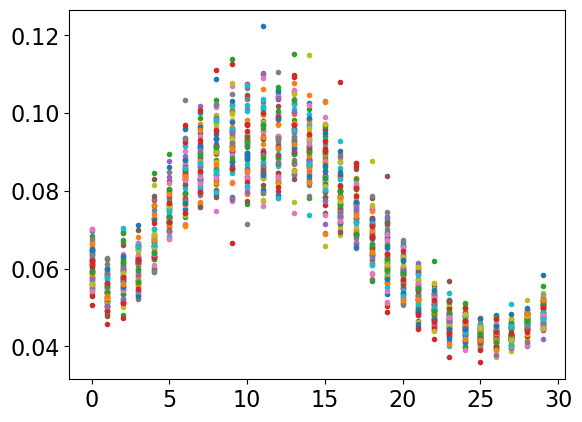

In [42]:
plt.plot(std_ll['g_amp'].reshape(N_time, N_ant), '.');
# plt.semilogy()

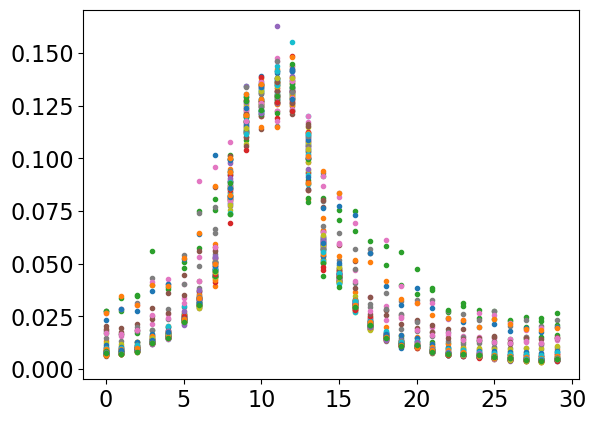

In [43]:
plt.plot(std_ll['g_phase'].reshape(N_time, N_ant-1), '.');
# plt.semilogy()

In [55]:
nll = vmap(nlog_likelihood, in_axes=(None,None,0,0,0))(MAP, params, a1, a2, bl) 

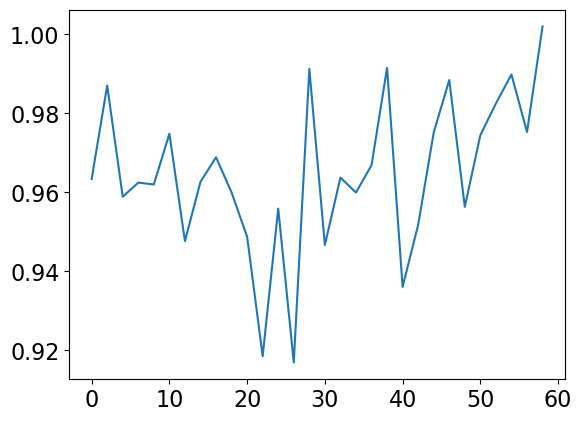

In [58]:
plt.plot(ds['times'], nll.mean(axis=0))

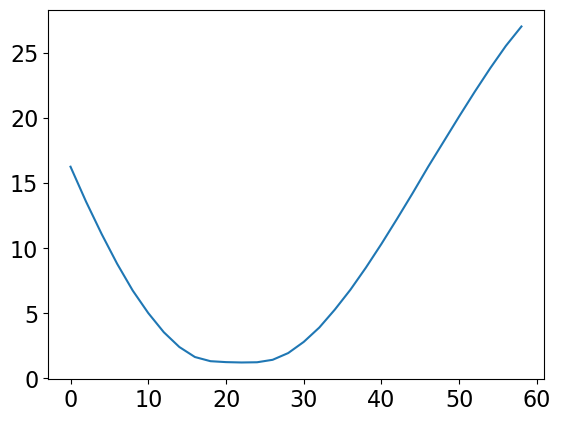

In [50]:
plt.plot(ds['times'], jnp.abs(ds['vis_obs']).mean(axis=1))

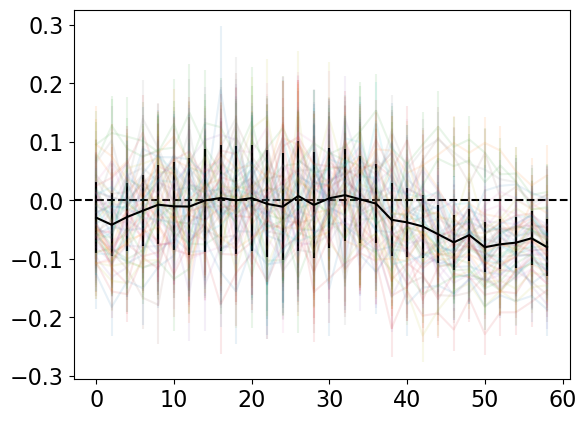

In [69]:
mean = MAP['g_amp'].reshape(N_time, N_ant)
err = std_ll['g_amp'].reshape(N_time, N_ant)
true = true_values['g_amp'].reshape(N_time, N_ant)
for i in range(N_ant):
    plt.errorbar(ds['times'], mean[:,i]-true[:,i], err[:,i], alpha=0.1)
    
plt.errorbar(ds['times'], (mean-true).mean(axis=1), (err/true).mean(axis=1), markersize=100, color='k')
plt.axhline(0.0, color='k', linestyle='--')

<ErrorbarContainer object of 3 artists>

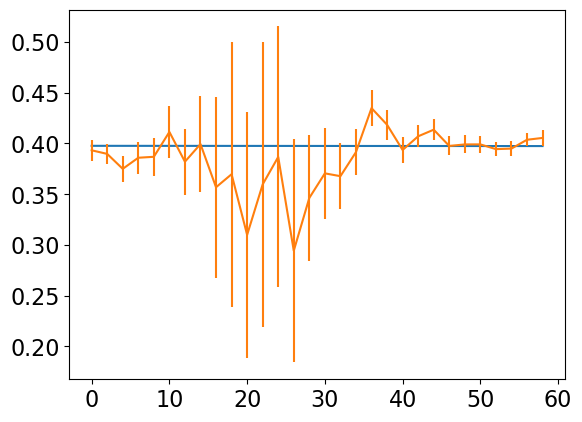

In [46]:
plt.plot(ds['times'], true_values['g_phase'].reshape(N_time, N_ant-1)[:,0])
plt.errorbar(ds['times'], MAP['g_phase'].reshape(N_time, N_ant-1)[:,0], std_ll['g_phase'].reshape(N_time, N_ant-1)[:,0])

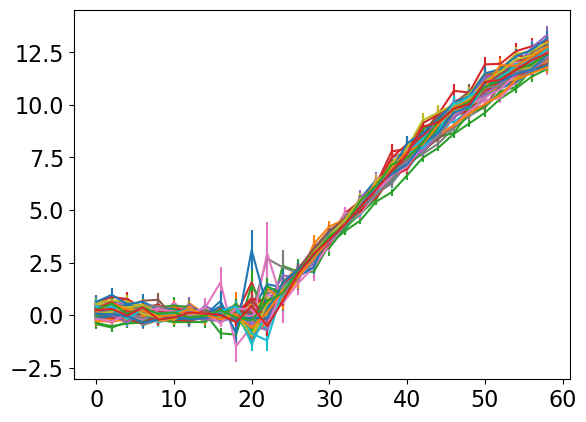

In [52]:
# plt.plot(ds['times'], true_values['rfi_amp'].reshape(N_time, N_ant)[:,0])
mean = MAP['rfi_amp'].reshape(N_time, N_ant)
err = std_ll['rfi_amp'].reshape(N_time, N_ant)
true = true_values['rfi_amp'].reshape(N_time, N_ant)
for i in range(N_ant): 
    plt.errorbar(x=ds['times'], y=mean[:,i]-true[:,i], yerr=err[:,i])
# plt.errorbar(x=ds['times'], y=mean, yerr=err)
# plt.plot(ds['times'], true, 'k')
# plt.semilogy()

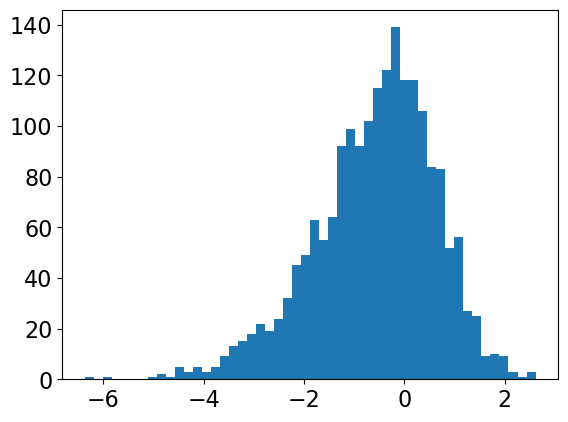

In [49]:
key = 'g_amp'
bias = (MAP[key]-true_values[key])/std_ll[key]
plt.hist(bias, bins=50);

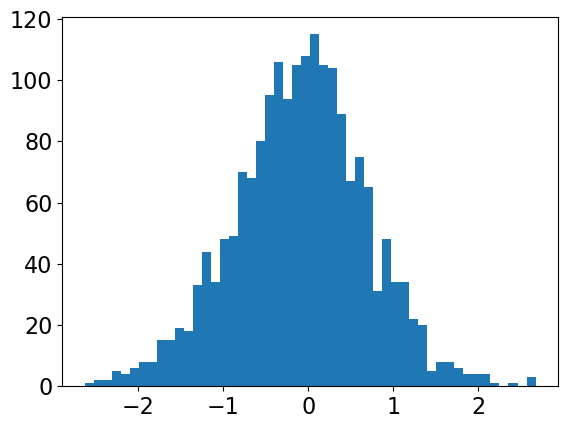

In [146]:
key = 'g_phase'
bias = (MAP[key]-true_values[key])/std[key]
plt.hist(bias, bins=50);

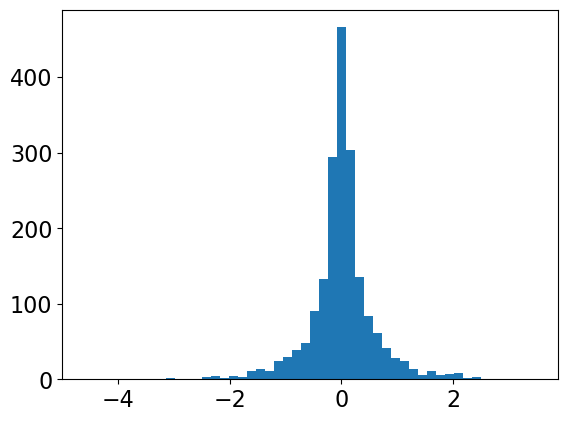

In [147]:
key = 'rfi_amp'
bias = (MAP[key]-true_values[key])/std[key]
plt.hist(bias, bins=50);